# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.317629
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Because we assume that all classes are equally distributed and equation under the log will close to 1/10 = 0.1*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -3.190581 analytic: -3.190581, relative error: 9.240005e-09
numerical: -3.214506 analytic: -3.214506, relative error: 8.082198e-09
numerical: 0.037820 analytic: 0.037820, relative error: 4.044042e-07
numerical: 2.379752 analytic: 2.379752, relative error: 1.199829e-08
numerical: 2.395646 analytic: 2.395646, relative error: 2.541865e-09
numerical: -5.132501 analytic: -5.132501, relative error: 1.317823e-08
numerical: 0.744267 analytic: 0.744267, relative error: 2.530428e-08
numerical: 0.429383 analytic: 0.429383, relative error: 6.991284e-08
numerical: -0.436345 analytic: -0.436345, relative error: 1.458362e-09
numerical: 1.059291 analytic: 1.059291, relative error: 9.126426e-08
numerical: -0.058604 analytic: -0.060209, relative error: 1.350986e-02
numerical: -0.653015 analytic: -0.647506, relative error: 4.235902e-03
numerical: 0.311931 analytic: 0.304397, relative error: 1.222351e-02
numerical: 1.014163 analytic: 1.017654, relative error: 1.718015e-03
numerical: 0.156081 an

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.317629e+00 computed in 0.140432s
vectorized loss: 2.317629e+00 computed in 0.014379s
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
import itertools as it
results = {}

best_val = -1
best_softmax = None

learning_rates = np.logspace(-9, -5, num=9)
regularization_strengths = np.logspace(2, 6, num=13)
combs = it.product(learning_rates, regularization_strengths)
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr, reg in combs:
    print(lr, reg)
    softmax = Softmax()
    loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                              num_iters=1500, verbose=True)
    y_train_pred = softmax.predict(X_train)
    y_val_pred = softmax.predict(X_val)
    
    train_acc = np.mean(y_train == y_train_pred)
    val_acc = (np.mean(y_val == y_val_pred))

    results[(lr, reg)] = (train_acc, val_acc)
    if best_val < val_acc:
        best_val = val_acc
        best_softmax = softmax
        best_lr = lr
        best_reg = reg
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

1e-09 100.0
iteration 0 / 1500: loss 8.663401
iteration 100 / 1500: loss 9.074318
iteration 200 / 1500: loss 8.492918
iteration 300 / 1500: loss 8.665136
iteration 400 / 1500: loss 8.567482
iteration 500 / 1500: loss 8.770124
iteration 600 / 1500: loss 8.725410
iteration 700 / 1500: loss 8.653277
iteration 800 / 1500: loss 8.503920
iteration 900 / 1500: loss 8.571812
iteration 1000 / 1500: loss 8.249680
iteration 1100 / 1500: loss 8.483242
iteration 1200 / 1500: loss 8.135791
iteration 1300 / 1500: loss 8.341938
iteration 1400 / 1500: loss 8.911495
1e-09 215.443469003
iteration 0 / 1500: loss 12.007899
iteration 100 / 1500: loss 12.000319
iteration 200 / 1500: loss 12.123497
iteration 300 / 1500: loss 11.748989
iteration 400 / 1500: loss 11.847371
iteration 500 / 1500: loss 11.781560
iteration 600 / 1500: loss 11.886037
iteration 700 / 1500: loss 11.509335
iteration 800 / 1500: loss 12.092792
iteration 900 / 1500: loss 11.427069
iteration 1000 / 1500: loss 11.889408
iteration 1100 / 15

iteration 1400 / 1500: loss 7.463674
3.16227766017e-09 215.443469003
iteration 0 / 1500: loss 12.025769
iteration 100 / 1500: loss 12.034300
iteration 200 / 1500: loss 12.206860
iteration 300 / 1500: loss 11.473561
iteration 400 / 1500: loss 11.910030
iteration 500 / 1500: loss 12.143746
iteration 600 / 1500: loss 11.644297
iteration 700 / 1500: loss 11.701268
iteration 800 / 1500: loss 11.097462
iteration 900 / 1500: loss 12.027999
iteration 1000 / 1500: loss 11.139318
iteration 1100 / 1500: loss 11.175888
iteration 1200 / 1500: loss 11.255591
iteration 1300 / 1500: loss 11.097068
iteration 1400 / 1500: loss 10.824948
3.16227766017e-09 464.158883361
iteration 0 / 1500: loss 19.612243
iteration 100 / 1500: loss 19.753032
iteration 200 / 1500: loss 19.613250
iteration 300 / 1500: loss 19.408800
iteration 400 / 1500: loss 19.636926
iteration 500 / 1500: loss 19.281524
iteration 600 / 1500: loss 19.185184
iteration 700 / 1500: loss 19.299777
iteration 800 / 1500: loss 18.613529
iteration 

iteration 1000 / 1500: loss 10.538462
iteration 1100 / 1500: loss 10.844959
iteration 1200 / 1500: loss 10.564365
iteration 1300 / 1500: loss 10.348932
iteration 1400 / 1500: loss 10.529911
1e-08 464.158883361
iteration 0 / 1500: loss 20.062582
iteration 100 / 1500: loss 19.133818
iteration 200 / 1500: loss 19.294784
iteration 300 / 1500: loss 18.542324
iteration 400 / 1500: loss 19.050341
iteration 500 / 1500: loss 19.014070
iteration 600 / 1500: loss 18.645329
iteration 700 / 1500: loss 18.272247
iteration 800 / 1500: loss 18.014738
iteration 900 / 1500: loss 18.213203
iteration 1000 / 1500: loss 18.030364
iteration 1100 / 1500: loss 17.830419
iteration 1200 / 1500: loss 17.866603
iteration 1300 / 1500: loss 18.012766
iteration 1400 / 1500: loss 17.901287
1e-08 1000.0
iteration 0 / 1500: loss 37.303765
iteration 100 / 1500: loss 36.826848
iteration 200 / 1500: loss 36.133162
iteration 300 / 1500: loss 35.896241
iteration 400 / 1500: loss 35.221835
iteration 500 / 1500: loss 34.983773

iteration 1100 / 1500: loss 16.853987
iteration 1200 / 1500: loss 16.737996
iteration 1300 / 1500: loss 16.651543
iteration 1400 / 1500: loss 16.392511
3.16227766017e-08 1000.0
iteration 0 / 1500: loss 35.771502
iteration 100 / 1500: loss 35.498216
iteration 200 / 1500: loss 34.874668
iteration 300 / 1500: loss 34.284102
iteration 400 / 1500: loss 33.793969
iteration 500 / 1500: loss 33.360047
iteration 600 / 1500: loss 33.473709
iteration 700 / 1500: loss 32.661431
iteration 800 / 1500: loss 32.624406
iteration 900 / 1500: loss 32.146394
iteration 1000 / 1500: loss 32.043389
iteration 1100 / 1500: loss 31.895876
iteration 1200 / 1500: loss 31.513717
iteration 1300 / 1500: loss 31.294821
iteration 1400 / 1500: loss 31.273680
3.16227766017e-08 2154.43469003
iteration 0 / 1500: loss 72.128488
iteration 100 / 1500: loss 69.910871
iteration 200 / 1500: loss 69.163564
iteration 300 / 1500: loss 67.819726
iteration 400 / 1500: loss 66.418106
iteration 500 / 1500: loss 65.584814
iteration 600

iteration 1200 / 1500: loss 26.409612
iteration 1300 / 1500: loss 26.098835
iteration 1400 / 1500: loss 25.595291
1e-07 2154.43469003
iteration 0 / 1500: loss 72.296226
iteration 100 / 1500: loss 67.120176
iteration 200 / 1500: loss 63.994211
iteration 300 / 1500: loss 60.993381
iteration 400 / 1500: loss 58.316976
iteration 500 / 1500: loss 55.790289
iteration 600 / 1500: loss 53.337257
iteration 700 / 1500: loss 50.808417
iteration 800 / 1500: loss 48.735757
iteration 900 / 1500: loss 46.738125
iteration 1000 / 1500: loss 44.747285
iteration 1100 / 1500: loss 43.043491
iteration 1200 / 1500: loss 41.155687
iteration 1300 / 1500: loss 39.617585
iteration 1400 / 1500: loss 37.885966
1e-07 4641.58883361
iteration 0 / 1500: loss 148.946630
iteration 100 / 1500: loss 134.383034
iteration 200 / 1500: loss 122.220274
iteration 300 / 1500: loss 110.884876
iteration 400 / 1500: loss 100.900992
iteration 500 / 1500: loss 91.957281
iteration 600 / 1500: loss 83.761036
iteration 700 / 1500: loss

iteration 100 / 1500: loss 108.901292
iteration 200 / 1500: loss 81.161383
iteration 300 / 1500: loss 60.703322
iteration 400 / 1500: loss 45.560939
iteration 500 / 1500: loss 34.366562
iteration 600 / 1500: loss 25.953714
iteration 700 / 1500: loss 19.844267
iteration 800 / 1500: loss 15.052736
iteration 900 / 1500: loss 11.753255
iteration 1000 / 1500: loss 9.316016
iteration 1100 / 1500: loss 7.496868
iteration 1200 / 1500: loss 6.075082
iteration 1300 / 1500: loss 4.949881
iteration 1400 / 1500: loss 4.162346
3.16227766017e-07 10000.0
iteration 0 / 1500: loss 311.871946
iteration 100 / 1500: loss 164.755121
iteration 200 / 1500: loss 87.892481
iteration 300 / 1500: loss 47.311497
iteration 400 / 1500: loss 25.950180
iteration 500 / 1500: loss 14.676286
iteration 600 / 1500: loss 8.684497
iteration 700 / 1500: loss 5.509213
iteration 800 / 1500: loss 3.893188
iteration 900 / 1500: loss 3.029408
iteration 1000 / 1500: loss 2.542694
iteration 1100 / 1500: loss 2.324609
iteration 1200 

iteration 700 / 1500: loss 2.075765
iteration 800 / 1500: loss 2.049857
iteration 900 / 1500: loss 2.023190
iteration 1000 / 1500: loss 2.062578
iteration 1100 / 1500: loss 2.000925
iteration 1200 / 1500: loss 2.082044
iteration 1300 / 1500: loss 2.073399
iteration 1400 / 1500: loss 2.025020
1e-06 21544.3469003
iteration 0 / 1500: loss 661.333987
iteration 100 / 1500: loss 10.365058
iteration 200 / 1500: loss 2.250955
iteration 300 / 1500: loss 2.141926
iteration 400 / 1500: loss 2.140873
iteration 500 / 1500: loss 2.125225
iteration 600 / 1500: loss 2.140549
iteration 700 / 1500: loss 2.125663
iteration 800 / 1500: loss 2.149433
iteration 900 / 1500: loss 2.046854
iteration 1000 / 1500: loss 2.141235
iteration 1100 / 1500: loss 2.137052
iteration 1200 / 1500: loss 2.123520
iteration 1300 / 1500: loss 2.196068
iteration 1400 / 1500: loss 2.187018
1e-06 46415.8883361
iteration 0 / 1500: loss 1433.934704
iteration 100 / 1500: loss 2.288075
iteration 200 / 1500: loss 2.172284
iteration 30

iteration 1300 / 1500: loss 2.137727
iteration 1400 / 1500: loss 2.294756
3.16227766017e-06 46415.8883361
iteration 0 / 1500: loss 1443.906605
iteration 100 / 1500: loss 2.208930
iteration 200 / 1500: loss 2.222653
iteration 300 / 1500: loss 2.309563
iteration 400 / 1500: loss 2.261817
iteration 500 / 1500: loss 2.242330
iteration 600 / 1500: loss 2.206190
iteration 700 / 1500: loss 2.267209
iteration 800 / 1500: loss 2.269163
iteration 900 / 1500: loss 2.241685
iteration 1000 / 1500: loss 2.246407
iteration 1100 / 1500: loss 2.359205
iteration 1200 / 1500: loss 2.260324
iteration 1300 / 1500: loss 2.261943
iteration 1400 / 1500: loss 2.205129
3.16227766017e-06 100000.0
iteration 0 / 1500: loss 3061.564496
iteration 100 / 1500: loss 2.303155
iteration 200 / 1500: loss 2.286007
iteration 300 / 1500: loss 2.301007
iteration 400 / 1500: loss 2.417692
iteration 500 / 1500: loss 2.295036
iteration 600 / 1500: loss 2.401379
iteration 700 / 1500: loss 2.310637
iteration 800 / 1500: loss 2.301

cs231n/classifiers/softmax.py:89: RuntimeWarning: divide by zero encountered in log
  loss = -np.log(softmax_val[idx_train, y]).sum()
cs231n/classifiers/softmax.py:88: RuntimeWarning: invalid value encountered in divide
  softmax_val = classes / np.sum(classes, axis=1)[:, None]


iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
1e-05 100.0
iteration 0 / 1500: loss 9.110276
iteration 100 / 1500: loss 5.131049
iteration 200 / 1500: loss 4.422302
iteration 300 / 1500: loss 4.305910
iteration 400 / 1500: loss 4.330189
iteration 500 / 1500: loss 4.211967
iteration 600 / 1500: loss 3.003769
iteration 700 / 1500: loss 3.648379
iteration 800 / 1500: loss 2.845863
iteration 900 / 1500: loss 3.752576
iteration 1000 / 1500: loss 3.473529
iteration 1100 / 1500: loss 2.343813
iteration 1200 / 1500: loss 3.311404
iteration 1300 / 1500: loss 2.560036
iteration 1400 / 1500: loss 2.742212
1e-05 

In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.380000


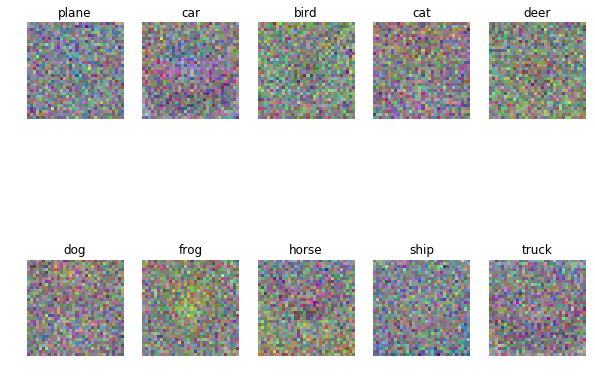

In [8]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])